# Neural Collaborative Filtering (NNCF)
***
Besides classical matrix factorization, we also implemented the neural network version of collaborative filtering: using deep network model to perform matrix factorization, as well as allowing extra playlist-track mixing. 

The code implemented here was adopted from this 2017 WWW paper on __[Neural Collaborative Filtering](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf)__ and a comprehensive __[blogpost](https://nipunbatra.github.io/blog/2017/neural-collaborative-filtering.html)__ written by Dr. Nipun Batra, Assistant Professor in Computer Science Department at IIT Gandhinagar. We applied the architecture of the NNCF model to a subset of data consisting of 10,000 playlists genereated with a seed track (a popular song that belongs to >10,000 playlists), training the network to perform binary classifcation on playlist-track pairs (predicting 0 vs. 1), and evaluated the model performance.

***
First we import the libraries.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy
import pickle
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import itertools
%matplotlib inline

Using TensorFlow backend.


## Load data and model

***
Here we loaded the sparse matrix containing track-playlist contingency.

In [2]:
# load files
sps_acc = sps.load_npz('sparse_10000.npz')

In [3]:
# convert matrix to csc type
sps_acc = sps_acc.tocsc()
sps_acc

<74450x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 1030015 stored elements in Compressed Sparse Column format>

## Set up model architecture
***
For building the model, we need to determine the number of latent factors for the embedding layers of ***matrix factorization stream***, as well as those for the ***multilayer perceptron stream***, for both playlist and track inputs. We set the former to 50, and the latter to 10, as a simple start.

In [4]:
# set latent factor number
n_tracks, n_playlists = sps_acc.shape[0], sps_acc.shape[1]
n_latent_mf = 50
n_latent_playlist = 10
n_latent_track = 10

## Network architecture
***
This architecture was adopted from the blogpost mentioned above. For the final prediction layer, we set it to a 2-unit dense connected layer for binary classification with softmax activation, and used binary crossentropy as loss function. We compiled the model with Adam optimizer, with a mild learning rate decay. 

In [5]:
# build model
from keras.layers import Input, Embedding, Flatten, Dropout, Concatenate, Dot, BatchNormalization, Dense

# track embedding stream
track_input = Input(shape=[1],name='Track')
track_embedding_mlp = Embedding(n_tracks + 1, n_latent_track, name='track-Embedding-MLP')(track_input)
track_vec_mlp = Flatten(name='Flatten_tracks-MLP')(track_embedding_mlp)
track_vec_mlp = Dropout(0.2)(track_vec_mlp)

track_embedding_mf = Embedding(n_tracks + 1, n_latent_mf, name='track-Embedding-MF')(track_input)
track_vec_mf = Flatten(name='Flatten_tracks-MF')(track_embedding_mf)
track_vec_mf = Dropout(0.2)(track_vec_mf)

# playlist embedding stream
playlist_input = Input(shape=[1],name='Playlist')
playlist_vec_mlp = Flatten(name='Flatten_playlists-MLP')(Embedding(n_playlists + 1, n_latent_playlist,name='playlist-Embedding-MLP')(playlist_input))
playlist_vec_mlp = Dropout(0.2)(playlist_vec_mlp)

playlist_vec_mf = Flatten(name='Flatten_playlists-MF')(Embedding(n_playlists + 1, n_latent_mf,name='playlist-Embedding-MF')(playlist_input))
playlist_vec_mf = Dropout(0.2)(playlist_vec_mf)

# MLP stream
concat = Concatenate(axis=-1,name='Concat')([track_vec_mlp, playlist_vec_mlp])
concat_dropout = Dropout(0.2)(concat)
dense = Dense(200,name='FullyConnected')(concat_dropout)
dense_batch = BatchNormalization(name='Batch')(dense)
dropout_1 = Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = Dense(100,name='FullyConnected-1')(dropout_1)
dense_batch_2 = BatchNormalization(name='Batch-2')(dense_2)
dropout_2 = Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

# end prediction for both streams
pred_mf = Dot(1,name='Dot')([track_vec_mf, playlist_vec_mf])
pred_mlp = Dense(1, activation='relu',name='Activation')(dense_4)

# combine both stream
combine_mlp_mf = Concatenate(axis=-1,name='Concat-MF-MLP')([pred_mf, pred_mlp])
result_combine = Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = Dense(100,name='FullyConnected-4')(result_combine)

# final prediction layer
result = Dense(2, activation = 'softmax', name='Prediction')(deep_combine)

# build model
model = keras.Model([playlist_input, track_input], result)

# compile model
opt = keras.optimizers.Adam(lr = 0.1, decay = 1e-5)
model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy'])

Here is the visualization and summary of the model.

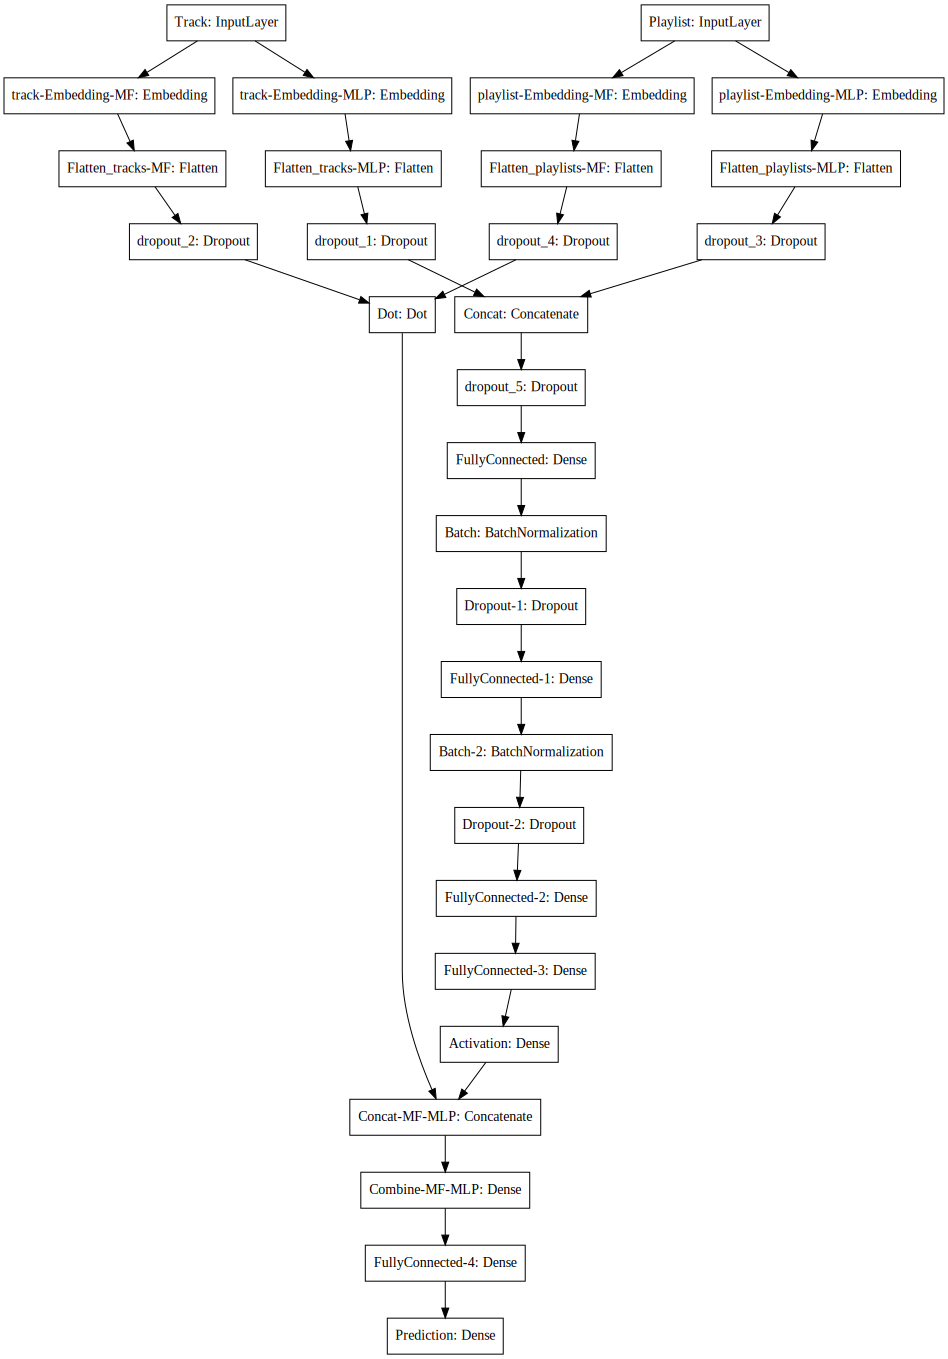

In [6]:
# visualize model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [7]:
# print out model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Track (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Playlist (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
track-Embedding-MLP (Embedding) (None, 1, 10)        744510      Track[0][0]                      
__________________________________________________________________________________________________
playlist-Embedding-MLP (Embeddi (None, 1, 10)        100010      Playlist[0][0]                   
__________________________________________________________________________________________________
Flatten_tr

## Spliting data
***
We split 5% of the data from the whole dataset, and distributed the 5% equally into validation and test set. From the summary statistics, we can see that the matrix is really sparse: only ~0.1% of pair had class 1 labels. 

In [11]:
# split data for training vs. validation/testing
data_size = n_playlists*n_tracks

# split a portion of pairs for validation and test
split_ratio = 0.05
split_num = int(data_size*split_ratio)

split_tracks = np.random.choice(n_tracks, split_num).reshape(-1,)
split_playlists = np.random.choice(n_playlists, split_num).reshape(-1,)
split_values = np.array(sps_acc[split_tracks, split_playlists]).reshape(-1,)

split_pair = [(tr, pl) for tr,pl in zip(split_tracks,split_playlists)]

print('# of all sample =', data_size)
print('proportion of ones in all samples =', sps_acc.count_nonzero()/data_size)
print('# of split samples =',int(np.sum(split_values)))
print('proportion of ones in split sample =', np.mean(split_values))

# of all sample = 744500000
proportion of ones in all samples = 0.0013834989926124917
# of split samples = 51086
proportion of ones in split sample = 0.001372357286769644


In [12]:
# split the saved pairs into validation and test data
test_num = int(split_num/2)

test_tracks = split_tracks[:test_num]
test_playlists = split_playlists[:test_num]
test_values = split_values[:test_num]
test_target = keras.utils.to_categorical(test_values, num_classes=2)

val_tracks = split_tracks[test_num+1:]
val_playlists = split_playlists[test_num+1:]
val_values = split_values[test_num+1:]
val_target = keras.utils.to_categorical(val_values, num_classes=2)

A trick here: We masked the splited data by setting the value to 2, and later excluded them during training process.

In [13]:
# put split sample values to 2
sps_two = sps_acc
sps_two[split_tracks,split_playlists] = 2

/Users/shihyitseng/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


## Define training data generator
***
One important step we took for training was to artificially ***balance the class labels***. Since the class 1 pairs were extremely sparse, a network trained on the original data can end up predicting everything to 0. Actuaslly that was what we got when we started with the naive way. In the current version we presented here, the training generator yielded augemented data with equalized class number. This would force the network to pay more attention on the class 1 samples, and bias the network to have a higher prior to class 1 than the real prior (which was around 0.1%). But the "high" false positive rate is actually what we want! We need to make recommendation on extending the songs in a playlists, and the "false positive" samples would be the candidates for recommendation.

In [14]:
# define training sample generator (with balanced classes)

# build one-hot encoder
exampleCase = [0., 1.]
ohe = OneHotEncoder(categories='auto').fit(np.array(exampleCase).reshape((len(exampleCase), 1)))

def trainGenerator(sps_two, ohe, batch_size=10000, balance_ratio=0.5):
    while True:
        n_tracks = sps_two.shape[0]
        n_playlists = sps_two.shape[1]

        # find indices for non-zero values
        index = scipy.sparse.find(sps_two)

        # find number of ones and zeros in final yield
        num_ones = np.ceil(batch_size*balance_ratio).astype(int)
        num_zeros = batch_size - num_ones

        # extract tracks, playlists and labels
        tr = index[0] # track
        pl = index[1] # playlist
        la = index[2] # label

        # find where label == 1
        is_one = la == 1
        tr = tr[is_one]
        pl = pl[is_one]

        # select class one samples
        num = tr.shape[0]
        one_ind = np.random.choice(num, num_ones)
        one_tracks = tr[one_ind]
        one_playlists = pl[one_ind]
        one_values = np.ones((num_ones,1))

        # over-sample 2 times of target number for class zero randomly (and later exclude non-zero samples)
        rand_tracks = np.random.choice(n_tracks, num_zeros*2)
        rand_playlists = np.random.choice(n_playlists, num_zeros*2)
        rand_values = np.array(sps_two[rand_tracks, rand_playlists]).reshape(-1,)

        # check to find class zero samples
        is_zero = rand_values == 0
        zero_tracks = rand_tracks[is_zero]
        zero_playlists = rand_playlists[is_zero]
        
        # grab zero entries with the target number
        zero_tracks = zero_tracks[:num_zeros]
        zero_playlists = zero_playlists[:num_zeros]
        zero_values = np.zeros((num_zeros,1))

        # concatenate class one and zeros
        sub_tracks = np.concatenate((one_tracks, zero_tracks))
        sub_playlists = np.concatenate((one_playlists, zero_playlists))
        values = np.concatenate((one_values, zero_values),axis = 0)
        target = ohe.transform(values).toarray()
        
        yield [sub_playlists, sub_tracks], target

The validation generator was defined similarly, generating samples from the validation set with equalized class number.

In [15]:
is_ones_val = np.array(val_values).reshape(-1,)==1
val_tracks_ones = val_tracks[is_ones_val]
val_playlists_ones = val_playlists[is_ones_val]

val_tracks_zeros = val_tracks[~is_ones_val]
val_playlists_zeros = val_playlists[~is_ones_val]

# define validation generator (with balanced classes)
def valGenerator_balance(val_tracks_ones, val_playlists_ones, val_tracks_zeros, val_playlists_zeros, 
                         ohe, val_batch_size=10000, balance_ratio = 0.5):
    while True:
        num_ones = int(val_batch_size*balance_ratio)
        num_zeros = val_batch_size - num_ones
        
        num_ones_total = val_tracks_ones.shape[0]
        num_zeros_total = val_tracks_zeros.shape[0]       
        
        ind_ones = np.random.choice(num_ones_total, num_ones)
        sub_val_tracks_ones = val_tracks_ones[ind_ones]
        sub_val_playlists_ones = val_playlists_ones[ind_ones]
        sub_val_values_ones = np.ones((num_ones,))
        
        ind_zeros = np.random.choice(num_zeros_total, num_zeros)
        sub_val_tracks_zeros = val_tracks_zeros[ind_zeros]
        sub_val_playlists_zeros = val_playlists_zeros[ind_zeros]
        sub_val_values_zeros = np.zeros((num_zeros,))
        
        sub_val_tracks = np.concatenate((sub_val_tracks_ones,sub_val_tracks_zeros))
        sub_val_playlists = np.concatenate((sub_val_playlists_ones,sub_val_playlists_zeros))
        sub_val_values = np.concatenate((sub_val_values_ones,sub_val_values_zeros))
        sub_val_target = ohe.transform(sub_val_values.reshape(-1,1)).toarray()
        
        yield [sub_val_playlists, sub_val_tracks], sub_val_target

## Model training
***
We set up checkpoints during the training process, saving models every 10 epochs. Later we can look at the training history and pick a model based on ***validation loss***, since the model can overfit during the extended training process (total 500 epochs).

In [16]:
# set checkpoints
filepath = "models_10000/model.{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=2, save_best_only=False, mode='auto', period=10)
callbacks_list = [checkpoint]

In [1]:
# fit model with validation data
history = model.fit_generator(trainGenerator(sps_two, ohe, batch_size=20000, balance_ratio=0.5), 
                              epochs=500, steps_per_epoch = 1, verbose=2, workers=1, use_multiprocessing=False,
                              validation_data=valGenerator_balance(val_tracks_ones, val_playlists_ones, 
                                                                   val_tracks_zeros, val_playlists_zeros, 
                                                                   ohe, val_batch_size=10000, balance_ratio = 0.5),
                              validation_steps=1,
                              callbacks=callbacks_list)

In [18]:
# save final model, training history, test/val data, and training matrix
model.save('final_model_10000_new_181210.h5')

with open('model_history_10000_new_181210.pkl', 'wb') as f0:
    pickle.dump(history, f0)

with open('test_tracks_10000_new_181210.pkl', 'wb') as f1:
    pickle.dump(test_tracks, f1)
with open('test_playlists_10000_new_181210.pkl', 'wb') as f2:
    pickle.dump(test_playlists, f2)
with open('test_values_10000_new_181210.pkl', 'wb') as f3:
    pickle.dump(test_values, f3)
    
with open('val_tracks_10000_new_181210.pkl', 'wb') as f4:
    pickle.dump(val_tracks, f4)
with open('val_playlists_10000_new_181210.pkl', 'wb') as f5:
    pickle.dump(val_playlists, f5)
with open('val_values_10000_new_181210.pkl', 'wb') as f6:
    pickle.dump(val_values, f6)
    
with open('sps_two_10000_new_181210.pkl', 'wb') as f7:
    pickle.dump(sps_two, f7)

## Training history
***
Plotted below is the training/validation loss during the training process. Both the training/validation loss dropped rapidly during the first 100 epochs, and and started to slow down between epoch 100 to 200. The training and validation loss started to diverge after epoch 200, as the training loss kept going down but the validation loss slowly increased. 

[Text(0,0.5,'Loss'), Text(0.5,0,'Epoch'), Text(0.5,1,'Loss')]

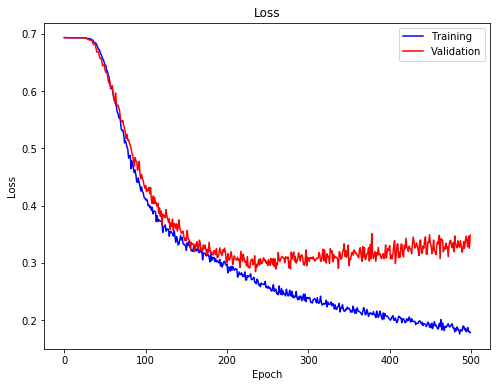

In [19]:
# plot loss of training process
fig, ax = plt.subplots(1,1,figsize = (8,6))
ax.plot(history.history['loss'],'b',label = 'Training')
ax.plot(history.history['val_loss'],'r',label='Validation')
ax.legend()
ax.set(xlabel='Epoch',ylabel = 'Loss', title= 'Loss')

We can also look at the accuracy of training and validation data. It reflected similar trend as indicated by the loss.

[Text(0,0.5,'Accuracy'), Text(0.5,0,'Epoch'), Text(0.5,1,'Accuracy')]

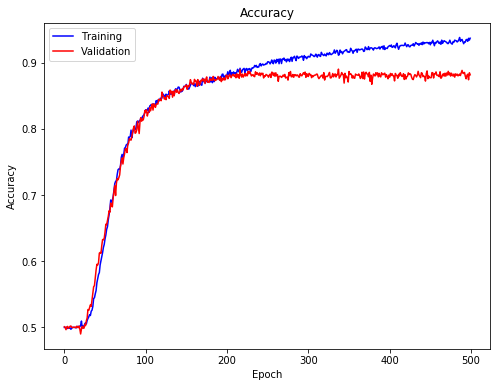

In [20]:
# plot accuaracy of training process
fig, ax = plt.subplots(1,1,figsize = (8,6))
ax.plot(history.history['acc'],'b',label = 'Training')
ax.plot(history.history['val_acc'],'r',label='Validation')
ax.legend()
ax.set(xlabel='Epoch',ylabel = 'Accuracy', title= 'Accuracy')

## Function to plot confusion matrix
***
We used the visualization function for confusion matrix from __[sklearn website](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)__.

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Evaluate the model
***
First, we evaluted the performance of the final model on test set. The accuracy was 93% before class balancing, and 88% after class balancing, which was really close to the training and validation performance at the final epochs.

In [22]:
# evaluate test data
test_target = keras.utils.to_categorical(test_values, num_classes=2)
test_result = model.evaluate([test_playlists, test_tracks],test_target)
print('Loss on test data =', test_result[0],
      '\nAccuracy on test data =', test_result[1])

18612500/18612500 [==============================] - 478s 26us/step
Loss on test data = 0.18031106435448713 
Accuracy on test data = 0.9366222699798394


In [23]:
# evaluate test data (class balanced) 
is_ones_test = np.array(test_values).reshape(-1,)==1
test_tracks_ones = test_tracks[is_ones_test]
test_playlists_ones = test_playlists[is_ones_test]

test_tracks_zeros = test_tracks[~is_ones_test]
test_playlists_zeros = test_playlists[~is_ones_test]

test_result_gen = model.evaluate_generator(valGenerator_balance(test_tracks_ones, test_playlists_ones, 
                                                                test_tracks_zeros, test_playlists_zeros, 
                                                                ohe, val_batch_size= 10000, balance_ratio = 0.5),
                                           steps = 100, verbose = 0)
print('Loss on test data =', test_result_gen[0],
      '\nAccuracy on test data =', test_result_gen[1])

Loss on test data = 0.3529369857907295 
Accuracy on test data = 0.8793360018730163


## Prediction and confusion matrix
***
We then made the prediction on test data and plotted confusion matrix (both non-normalized and normalized). The final model had sensitivity 82% (predicting class 1 from real class 1) and specificity of 94% (predicting class 0 from real 0). Notice that there were a lot of false positive samples, since we have an extremely unbalanced class ratio. Those samples would potentially be the ones that we make recommendation on.

In [24]:
# get prediction
y_prob = model.predict([test_playlists, test_tracks])
y_classes = y_prob.argmax(axis=-1)
print('predicted proportion of ones =', np.mean(y_classes))

predicted proportion of ones = 0.06425826729348556


Confusion matrix, without normalization
[[17411944  1175069]
 [    4549    20938]]


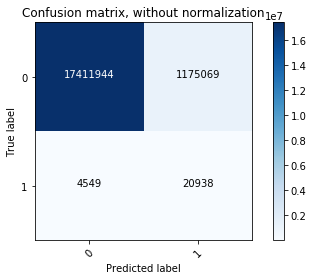

In [25]:
# compute and plot confusion matrix
cm = confusion_matrix(test_values, y_classes)
plot_confusion_matrix(cm, classes=[0,1],normalize=False,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.93678011 0.06321989]
 [0.17848315 0.82151685]]


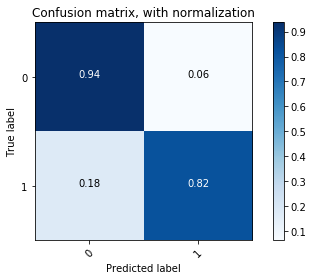

In [26]:
# plot confusion matrix (normalized)
plot_confusion_matrix(cm, classes=[0,1],normalize=True,
                      title='Confusion matrix, with normalization')

We can also quantify the model performance using area under ROC.

In [28]:
# calculate auROC
auroc_test = roc_auc_score(test_values, y_classes)
print('auROC =', auroc_test)

auROC = 0.8791484786391871


## Evaluation and prediction with the model of lowest validation loss
***
Since the final model might be a little bit overfitting according to the training histry, we went back and found the model with lowest validation loss (around epoch 220) that we saved as checkpoints, and evaluated the performance with it. 

In [29]:
# load best model
best_model_file = "models_10000/model.220-0.30-0.88.h5"
best_model = load_model(best_model_file)

In [30]:
# evaluate test data with the best model
test_target_best = keras.utils.to_categorical(test_values, num_classes=2)
test_result_best = best_model.evaluate([test_playlists, test_tracks],test_target)
print('Loss on test data =', test_result_best[0],
      '\nAccuracy on test data =', test_result_best[1])

18612500/18612500 [==============================] - 503s 27us/step
Loss on test data = 0.3220961782173249 
Accuracy on test data = 0.8845281934184144


In [31]:
# evaluate test data (class balanced) with the best model 
test_result_best_gen = best_model.evaluate_generator(valGenerator_balance(test_tracks_ones, test_playlists_ones, 
                                                                          test_tracks_zeros, test_playlists_zeros, 
                                                                          ohe, val_batch_size= 10000, balance_ratio = 0.5), 
                                                 steps = 100, verbose = 0)
print('Loss on test data (class balanced) =', test_result_best_gen[0],
      '\nAccuracy on test data (class balanced) =', test_result_best_gen[1])

Loss on test data (class balanced) = 0.313746480345726 
Accuracy on test data (class balanced) = 0.8772099989652634


We can see that the final model and the model with lowest validation loss performed similarly on class balanced test data, but the final model out-performed on the test data with real class ratio.

In [32]:
# get prediction on test data with the best model 
y_prob_best = best_model.predict([test_playlists, test_tracks])
y_classes_best = y_prob_best.argmax(axis=-1)
print('predicted proportion of ones =', np.mean(y_classes_best))

predicted proportion of ones = 0.11648354600402955


Confusion matrix, without normalization
[[16441122  2145891]
 [    3328    22159]]


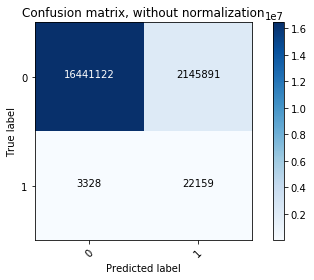

In [33]:
# compute and plot confusion matrix with the best model 
cm_best = confusion_matrix(test_values, y_classes_best)
plot_confusion_matrix(cm_best, classes=[0,1],normalize=False,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.88454891 0.11545109]
 [0.13057637 0.86942363]]


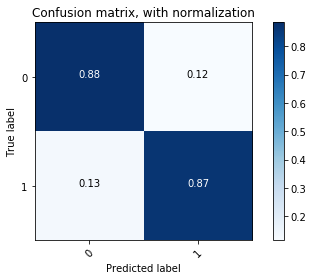

In [34]:
# plot confusion matrix (normalized) with the best model 
plot_confusion_matrix(cm_best, classes=[0,1],normalize=True,
                      title='Confusion matrix, with normalization')

In [36]:
# calculate auROC
auroc_test_best = roc_auc_score(test_values, y_classes_best)
print('auROC =', auroc_test_best)

auROC = 0.8769862664635207


## Comparison between models
***
When we looked at the normalized confusion matrix, we found that this model gave higher sensitivity on class 1 samples but lower specificity on class 0 samples compared to the final model. Since the validation data was also sampled in a class-balance way, it is biased toward the balanced statistics. But when we trained the model for longer, it learned the closer-to-real statistics of the original data, so it did well on the test set with original class values. The area under ROC metric for both models were quite similar. We think that both models were fine. The final model might give better accuracy on predicting playlist-track contingency, but the model with lowest validation loss had higher "false positive rate", therefore would give us a more extended list of recommendation.